<h1>ECC_analysis_v1.1</h1>
<div>by Oscar Amarilla</div>

<p>This notebook orchestrates each step of an academic project that consists of applying a machine learning algorithm to the topologycal data analysys (TDA) of the mean sea surface temperature (SST) of a region of the central tropical Pacific.</p>

<h3>Importing modules, packages and data needed for the code</h3>

In [1]:
import numpy as np
import pandas as pd
#import plotly.express as px
from src import config
from src.extract import sst_fields, monthly_34_sst_avg
from src.transform_and_load import TDA_process,ONI, mean_curve
from src.plots import *
from src.utils import *
from IPython.display import Image
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

<h2>1 - Extracting process</h2>
<p>The project needs two data, the first will be extracted from a netCDF file that contains the mean monthly SST from the period 1950-2021 from the region of interest defined by the coordinates (160ºE-270ºE,10ºN-10ºS), and the second is a csv file that contains data about the mean monthly SST of the Niño 3.4 region (170ºO-120ºO,5ºN-5ºS) of the same period of time.</p>
</br>
<p>The netCDF file containing the SST temperature can be adquired in the <a href='https://www.psl.noaa.gov/data/gridded/data.cobe.html'>Pysical Sciences Laboratory of the NOAA</a> and the data about the Niño 3.4 SST can be reached in the <a href='https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt'>Climate Prediction Center</a> of the same institution.</p>

In [2]:
sst = sst_fields(config.INPUT_DIR,config.FILES().nc_file)

<p>The following plot shows, in red, the region of the central tropical Pacific that is of interest for this project.</p>

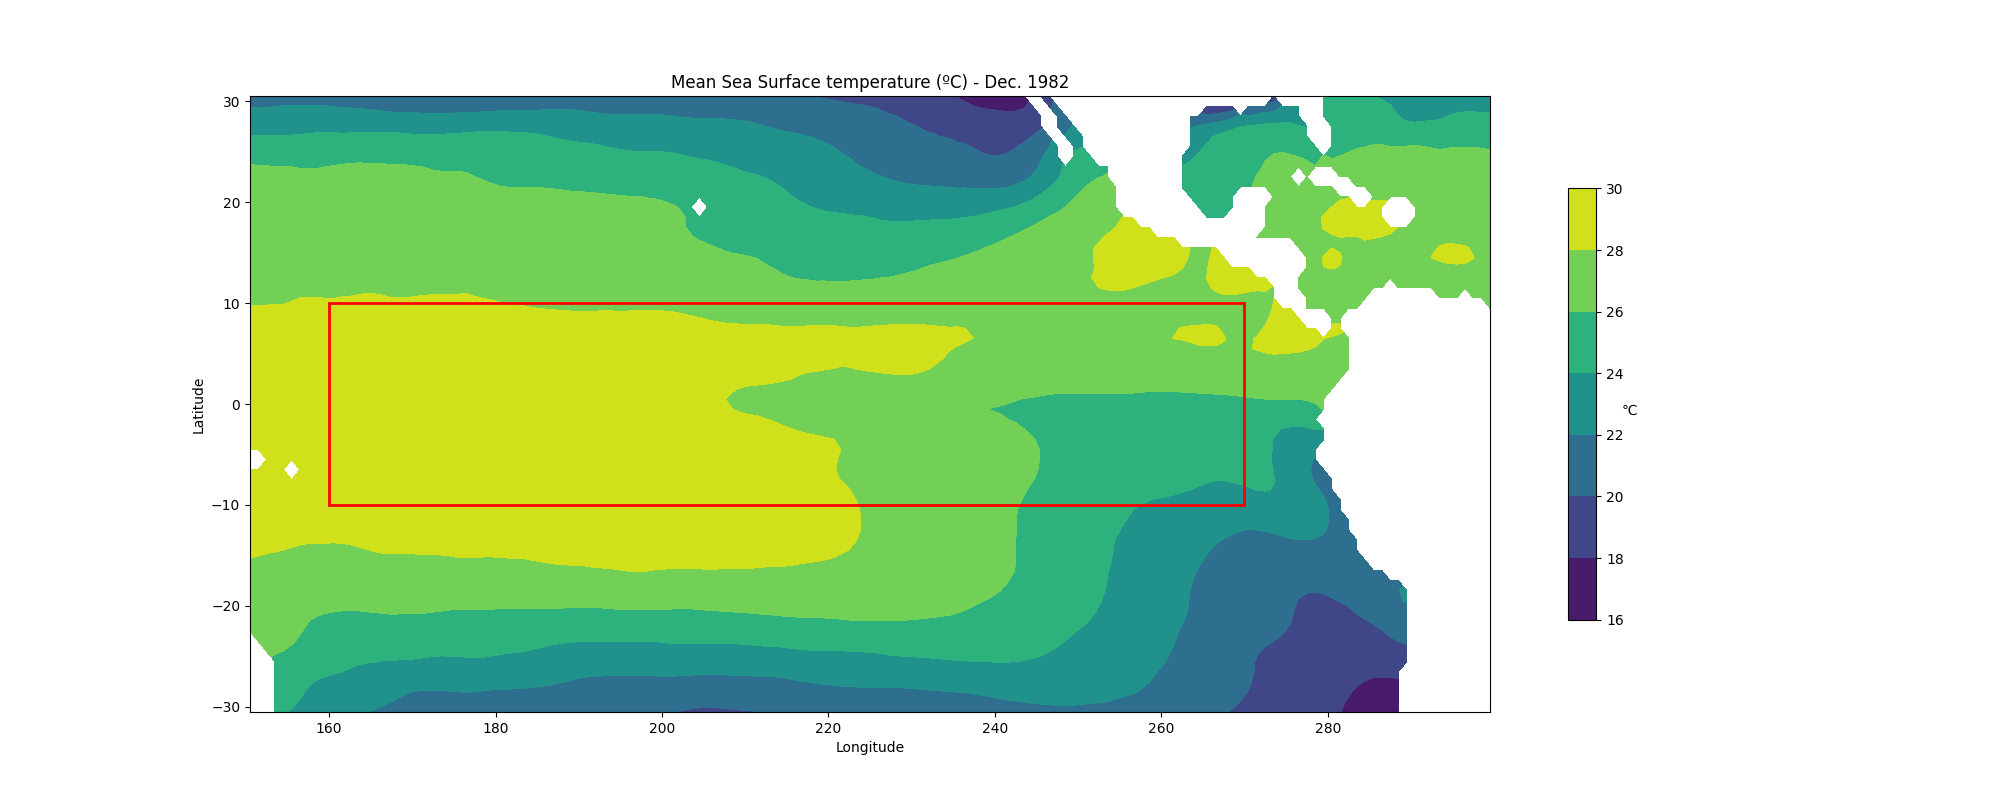

In [3]:
Image(filename='outputs/Dec._1982.png')

In [4]:
sst_34 = monthly_34_sst_avg(config.INPUT_DIR,config.FILES().csv_file)

In [5]:
sst_34.head()

,Year,Month,Anomaly (ºC)
0,1950,1,-1.62
1,1950,2,-1.32
2,1950,3,-1.07
3,1950,4,-1.11
4,1950,5,-1.37


<h2>2 - Transformation and loading process</h2>
<p>The TDA_process function performs two task:</p>
<ul>
    <li>The <a href='https://poe.com/s/CVt9fTJ73PXluwaeLO97'>sub-level set filtration</a> of each SST field</li>
    <li>The computation of the <a href='https://poe.com/s/GNsohOeUu8ZlKgfr4raI'>Euler characteristic curves</a> of each filtration</li>
</ul>

In [6]:
# database = TDA_process(sst)
database = pd.read_csv("input/database.csv", index_col=0)
database.columns = [x / 10 for x in range(180, 320)]
database.tail()

,18.0,18.1,18.2,18.3,18.4,18.5,18.6,18.7,18.8,18.9,...,31.0,31.1,31.2,31.3,31.4,31.5,31.6,31.7,31.8,31.9
2023_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023_9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023_11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023_12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, every SST field, which is taken as a surface will be reduced into a curve thanks to the TDA process.

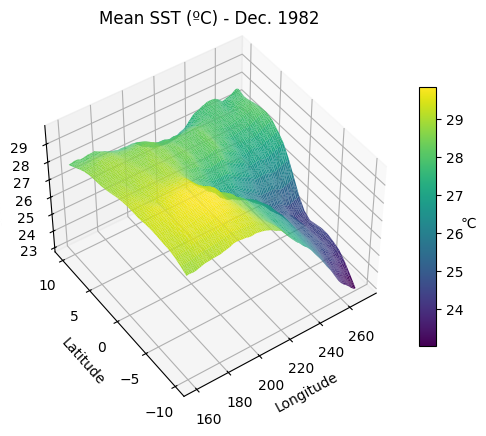

In [7]:
sst_field_plot(sst,1982,12)

<p>The outputs of the TDA_process function are curves, like the one shown below, that summarize the topological information of the surface displayed above.</p>

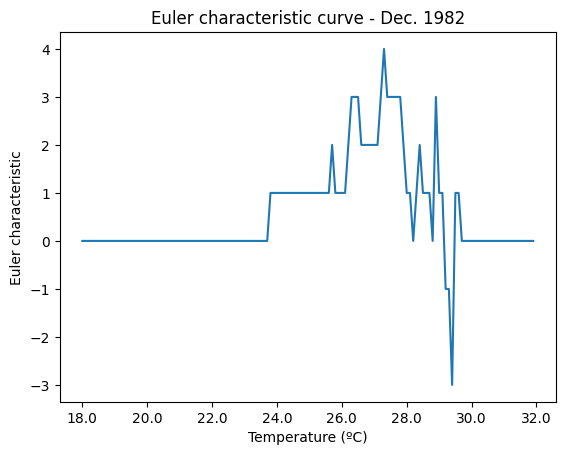

In [8]:
ecc_plot(database,1982,12)

<hr>

<p>The ONI function takes the sst_34 dataframe and computes the <a href='https://www.climate.gov/news-features/understanding-climate/climate-variability-oceanic-ni%C3%B1o-index'>Oceanic Niño Index (ONI)</a> to then place the ouputs in the <em>enso_info</em> dataframe as a new column.</p>
<p>Specifically, the ONI function assigns a numerical label to each row of the dataframe depending on the ESNO phase that corresponds to that particular month. These labels are:</p>
<ul>
    <li>Niña: 0</li>
    <li>Normal conditions: 1</li>
    <li>Niño: 2</li>
</ul>

In [9]:
enso_info = ONI(sst_34)

enso_info.tail()

,Year,Month,Anomaly (ºC),Phase
883,2023,8,1.35,2
884,2023,9,1.60,2
885,2023,10,1.72,2
886,2023,11,2.02,2
887,2023,12,2.02,2


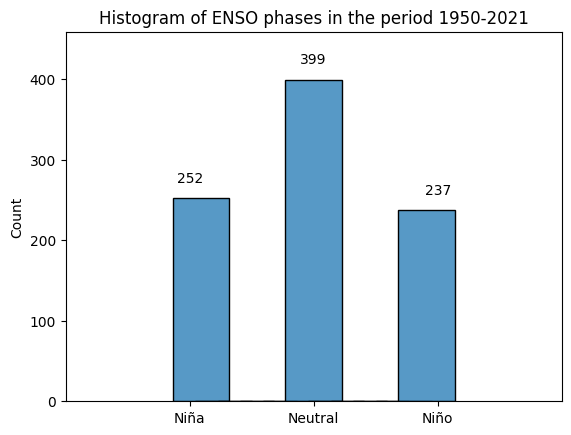

In [10]:
phases_histo(enso_info)

In [12]:
neutral_ecc = database.loc[list(enso_info['Phase']==1)]

ninha_ecc = database.loc[list(enso_info['Phase']==0)]

ninho_ecc = database.loc[list(enso_info['Phase']==2)]

In [14]:
ninha_ecc_dscr = mean_curve(ninha_ecc)

In [15]:
neutral_ecc_dscr = mean_curve(neutral_ecc)

In [16]:
ninho_ecc_dscr = mean_curve(ninho_ecc)

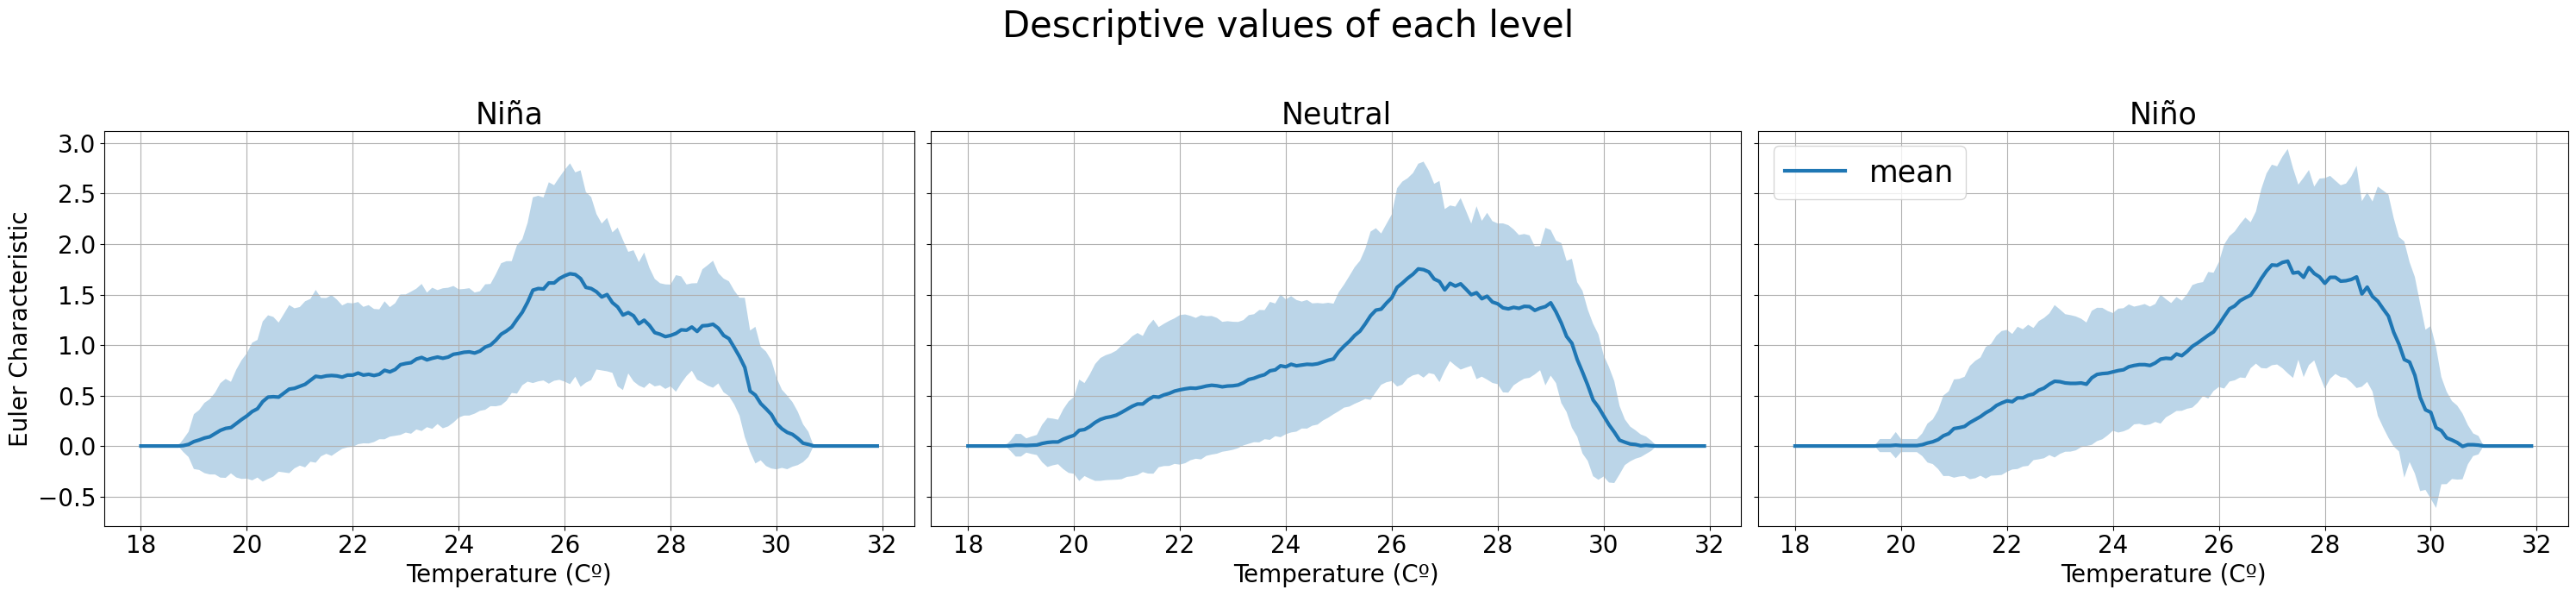

In [17]:
descr_phase_plot(ninha_ecc_dscr, neutral_ecc_dscr, ninho_ecc_dscr)

For a further analysis, the ECC will be grouped according to a label with respect to the SSTA into the following categories:

- Weak: 0.5ºC < |SSTA| < 1ºC
- Moderate: 1.0ºC $\leq$ |SSTA| < 1.5ºC
- Strong: 1.5 $\leq$ |SSTA| < 2ºC
- Very Strong: 2 $\leq$ |SSTA|

In [35]:
ninha_ecc_weak = database.loc[list((enso_info['Phase']==0) & (enso_info['Anomaly (ºC)']<-0.5) & (enso_info['Anomaly (ºC)']>-1))]

ninha_ecc_moderate = database.loc[list((enso_info['Phase']==0) & (enso_info['Anomaly (ºC)']<=-1) & (enso_info['Anomaly (ºC)']>-1.5))]

ninha_ecc_strong = database.loc[list((enso_info['Phase']==0) & (enso_info['Anomaly (ºC)']<=-1))]

ninho_ecc_weak = database.loc[list((enso_info['Phase']==2) & (enso_info['Anomaly (ºC)']>0.5) & (enso_info['Anomaly (ºC)']<1))]

ninho_ecc_moderate = database.loc[list((enso_info['Phase']==2) & (enso_info['Anomaly (ºC)']>=1) & (enso_info['Anomaly (ºC)']<=1.5))]

ninho_ecc_strong = database.loc[list((enso_info['Phase']==2) & (enso_info['Anomaly (ºC)']>=1))]

Now the mean ECC and the standard deviation of each group will be computed

In [ ]:
ninha_ecc_weak_dscr = mean_curve(ninha_ecc_weak)

ninha_ecc_moderate_dscr = mean_curve(ninha_ecc_moderate)

ninha_ecc_strong_dscr = mean_curve(ninha_ecc_strong)

ninho_ecc_weak_dscr = mean_curve(ninho_ecc_weak)

ninho_ecc_moderate_dscr = mean_curve(ninho_ecc_moderate)

ninho_ecc_strong_dscr = mean_curve(ninho_ecc_strong)

Having the descriptive values of each category of the Niña and Niño phases, these curves will be plotted to visualize the change along the different categories.

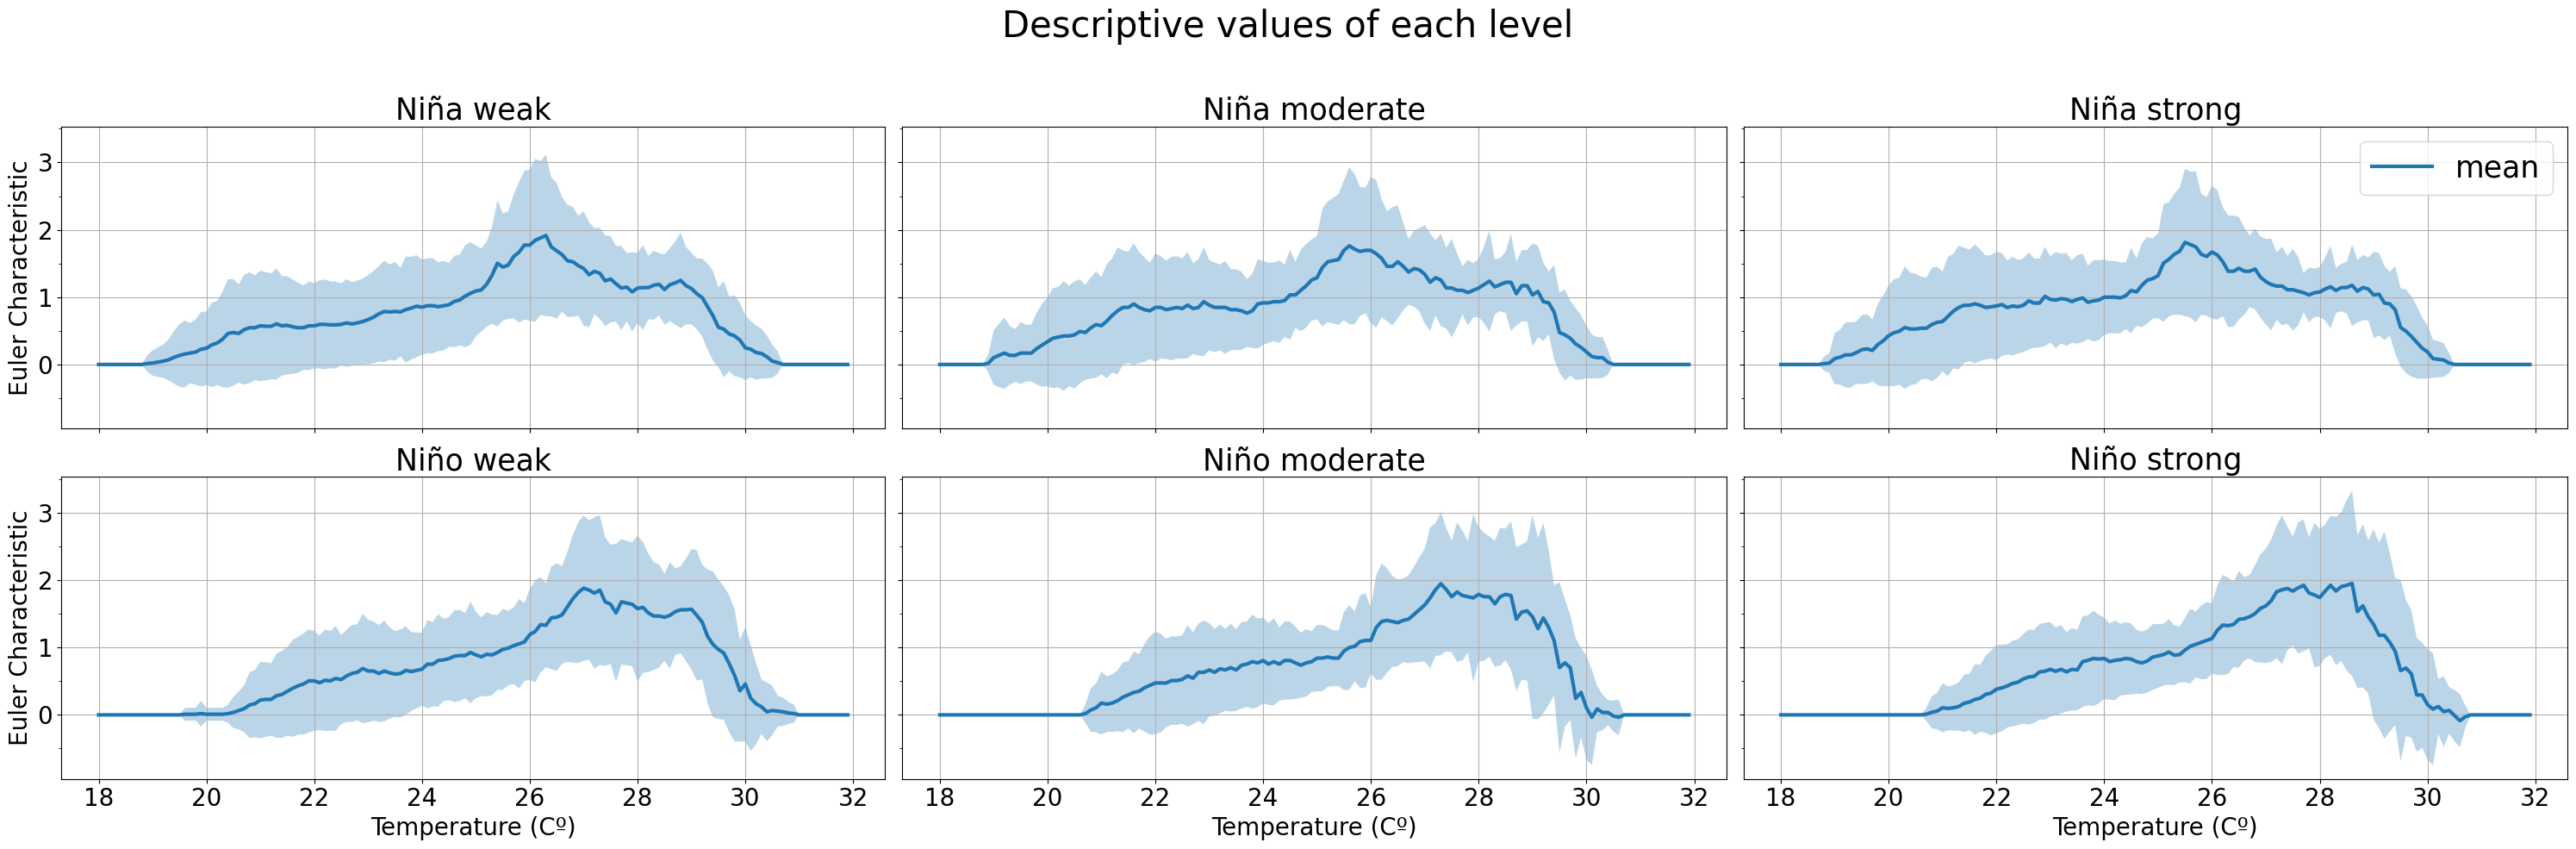

In [25]:
deep_descr_phase_plot(ninha_ecc_weak_dscr, 
    ninha_ecc_moderate_dscr, 
    ninha_ecc_strong_dscr,
    ninho_ecc_weak_dscr, 
    ninho_ecc_moderate_dscr, 
    ninho_ecc_strong_dscr)

It is visible that there are levels in which the Euler characteristic is zero, also that the levels showing interesting differences across the phases is between the 
25ºC and and 30ºC. Therfore, those levels with zero values across the phases will be removed in order to downscale the dimentionality of the data.

In [ ]:
# Counting zeros in each column
zeros_count = len(database) - database.eq(0).sum()

Those level whose Euler characteristic is below a hundred will be dropped, given that they give no relevant information. this can be seen in the following graph.

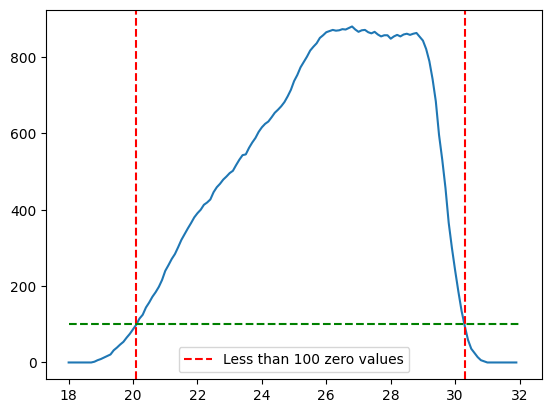

In [62]:
# Assuming zeros_count is a pandas Series
zeros_count.plot()

# Add vertical lines
plt.axvline(x=20.1, color='r', linestyle='--', label='Less than 100 zero values')
plt.axvline(x=30.3, color='r', linestyle='--')
plt.hlines(y=100, xmin=18, xmax=32, color='g', linestyle='--')

plt.legend()
plt.show()

In [66]:
# Display the result
print("Number of nonzeros values at each level:")
count = 0
for i, zeros in enumerate(zeros_count):
  if zeros < 100:
    count += 1
    print(round(18 + i*0.1, 2), zeros)

Number of nonzeros values at each volume:
18.0 0
18.1 0
18.2 0
18.3 0
18.4 0
18.5 0
18.6 0
18.7 0
18.8 2
18.9 6
19.0 9
19.1 13
19.2 17
19.3 21
19.4 32
19.5 39
19.6 47
19.7 54
19.8 65
19.9 75
20.0 87
20.1 99
30.3 95
30.4 59
30.5 36
30.6 25
30.7 14
30.8 6
30.9 3
31.0 0
31.1 0
31.2 0
31.3 0
31.4 0
31.5 0
31.6 0
31.7 0
31.8 0
31.9 0


In [69]:
print(f'Number of levels with less than 100 nonzeros values : {count}')

Number of levels with less than 100 nonzeros values : 39


The filtered version of the data will be exported to perform the application of machine learning algorithms.

In [65]:
database_filt = database.loc[:,20.2:30.2].copy()